# Detecção de fraudes em cartões de crédito

Por: [Francisco Bustamante](https://franciscobustamante.com.br/)

*Recomendada a abertura do notebook do Google Colab para uma melhor visualização.*

---

<center>
    <img alt="fraud" src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/fraud.jpg">
</center>

Nas últimas décadas, com o aumento constante de operações financeiras realizadas, fraudes com cartões de crédito têm se tornado um problema considerável. Grande poder computacional é direcionado para tentar detectar operações fraudulentas, especialmente com o uso cada mais intensivo de bancos online e e-commerce. Diversas estratégias de Data Mining e Machine Learning vêm sendo empregadas neste contexto.

Neste trabalho, utilizaremos uma base com dados de transações feitas com cartões de crédito e estudaremos diferentes algoritmos que podem ser utilizados para classificar uma determinada transação como fraudulenta ou não.

## Contextualização

<center>
    <img alt="hacked" src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/hacked.jpg">
</center>

### Breve descrição de um sistema de detecção de fraudes

Muitos tipos de fraudes podem ser realizados, desde omissão de fontes de renda, passando por lavagem de dinheiro, até clonagem de cartão. Na tentativa de se prevenir, a indústria financeira faz uso dos chamados *Sistemas Baseados em Regras*, também chamados de *Sistemas de Produção*, que armazenam e manipulam dados buscando inferir se uma determinada operação é fraudulenta ou não. Atualmente, tais sistemas fazem uso de ferramentas de machine learning.

Podemos imaginar um sistema de detecção de fraude em um banco como a figura a seguir. Há o banco de dados da instituição sobre o qual são realizados treinamentos de algoritmos gerando modelos que representam as características das transações armazenadas.

<a href="https://linktr.ee/flsbustamante"><img src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/fraud_flux.png" alt="fraud flux"></a>

<center>    
    <p style="font-size:80%;color:gray">Fluxograma de um Sistema de Detecção de Fraudes. Adaptado <a href="https://doi.org/10.22937/IJCSNS.2021.21.9.4">da literatura.</a></p>
</center>


O modelo, então, é usado para decidir se novas transações serão aceitas como genuínas ou recusadas como fraudulentas. Uma transação aceita será executada e adicionada ao banco de dados para melhorar o modelo. Uma recusada, será destinada para avaliação manual. Se for considerada genuína, será executada e adicionada à base de dados como tal. Caso se confirme a fraude, será confirmada a rejeição e registrada na base como efetivamente fraude.

Como vemos, parte crucial do processo é treinar um modelo que seja eficaz. Um modelo bem desenvolvido identificaria não apenas fraudes mas, também, determinaria a probabilidade de um comportamento fraudulento.

### Base de dados utilizada neste estudo

O dataset utilizado neste trabalho pode ser baixado [deste link do Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). Trata-se de uma base de dados com transações de cartões de crédito registradas por operadoras europeias em dois dias do mês de setembro de 2013. São 284.807 transações das quais apenas 492 foram registradas como fraudes. Observe a quantidade elevada de transações considerando que são apenas de dois dias (e de 8 anos atrás, imagine quanto deve ser o volume atualmente para um mesmo intervalo de tempo) e como é uma base de dados muito desbalanceada, já que somente 0,172 % do total de registros são fraudelentos.

Na próxima seção, faremos uma melhor descrição do dataset e começaremos a direcionar nossos esforços para como treinar um modelo eficaz com tal desbalanceamento.

## Importando bibliotecas e dados

A biblioteca [Imbalanced Learn](https://imbalanced-learn.org/stable/), como o nome indica, é uma biblioteca construída sobre o Scikit-Learn com o intuito de lidar melhor com datasets desbalanceados. Ela não vem em uma instalação padrão do Anaconda e não vem por padrão em uma máquina virtual do Google Colaboratory. Logo, se precisar instalar em seu ambiente, descomente e rode o código da célula a seguir:

In [1]:
# !pip install -U imbalanced-learn

Para facilitar a reprodução do presente estudo, o código da célula seguinte fornece as versões das bibliotecas utilizadas e a versão do interpretador Python utilizado:

In [2]:
import pandas as pd
import matplotlib
import seaborn as sns
import numpy as np
import imblearn
import sklearn
from platform import python_version

packages = {'Pandas': pd,
            'Matplotlib': matplotlib,
            'Seaborn': sns,
            'Numpy': np,
            'Scikit-Learn': sklearn,
            'Imbalanced-Learn': imblearn}

print('Versões das bibliotecas utilizadas no estudo:\n')
print('{0:-^20} | {1:-^10}'.format('', ''))
print('{0:^20} | {1:^10}'.format('Biblioteca', 'Versão'))
print('{0:-^20} | {1:-^10}'.format('', ''))

for name, alias in packages.items():
    print(f'{name:<20} | {alias.__version__:>10}')

print()
print('{0}: {1}'.format('Versão do Python', python_version()))

Versões das bibliotecas utilizadas no estudo:

-------------------- | ----------
     Biblioteca      |   Versão  
-------------------- | ----------
Pandas               |      1.3.3
Matplotlib           |      3.4.2
Seaborn              |     0.11.2
Numpy                |     1.20.3
Scikit-Learn         |      1.0.1
Imbalanced-Learn     |      0.8.1

Versão do Python: 3.9.7


Na célula seguinte, todos os métodos e classes necessários serão importados. O papel de cada um será descrito no decorrer do trabalho.

In [3]:
# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

# scaling
from sklearn.preprocessing import RobustScaler

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

# imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

A seguir, consideramos que o dataset foi baixado para uma pasta `data` na raiz do projeto. E, com o método `head`, vemos as 5 primeiras entradas da base de dados:

In [4]:
DATAFILE = 'data/creditcard.csv'

df = pd.read_csv(DATAFILE)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Vamos entender um pouco mais de nosso dataset.

## Análise exploratória dos dados (EDA)

<center>
    <img alt="eda" src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/eda.jpg">
</center>

### Resumo estatístico

Vejamos as dimensões:

In [5]:
print(f'Quantidade de entradas: {df.shape[0]}')
print(f'Quantidade de variáveis: {df.shape[1]}')

Quantidade de entradas: 284807
Quantidade de variáveis: 31


Como já havíamos discutido na introdução, temos 284807 entradas e 31 variáveis. Na [descrição da base de dados no Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud), são fornecidas algumas explicações acerca das variáveis:

- por questões de confidencialidade, não são disponibilizadas as identificações de boa parte das variáveis originais;
- as representadas como *V1, V2,... V28* são resultado de uma transformação de [análise de componentes principais - PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), uma técnica utilizada para condensar a informação contida em várias variáveis originais em um conjunto menor de variáveis estatísticas (componentes) com uma perda mínima de informação. Mais adiante veremos algumas consequências dessa transformação em nossa análise;
- as variáveis `Time` (tempo) e `Amount` (valor de cada transação) não passaram por PCA.
    - o tempo se refere ao intervalo, em segundos, entre cada transação e a primeira no dataset
- a variável `Class` é a variável alvo:
    - o valor `0` significa transação genuína, legítima
    - o valor `1` significa fraude

Vejamos as informações que os métodos `info` e `describe` nos fornecem:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
with pd.option_context('precision', 2, 'display.max_columns', 50):
    display(df.describe())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,284807.00,2.85e+05
mean,94813.86,3.92e-15,5.68e-16,-8.76e-15,2.81e-15,-1.55e-15,2.04e-15,-1.70e-15,-1.89e-16,-3.15e-15,1.77e-15,9.29e-16,-1.80e-15,1.67e-15,1.48e-15,3.50e-15,1.39e-15,-7.47e-16,4.26e-16,9.02e-16,5.13e-16,1.47e-16,8.04e-16,5.28e-16,4.46e-15,1.43e-15,1.70e-15,-3.66e-16,-1.22e-16,88.35,1.73e-03
std,47488.15,1.96e+00,1.65e+00,1.52e+00,1.42e+00,1.38e+00,1.33e+00,1.24e+00,1.19e+00,1.10e+00,1.09e+00,1.02e+00,9.99e-01,9.95e-01,9.59e-01,9.15e-01,8.76e-01,8.49e-01,8.38e-01,8.14e-01,7.71e-01,7.35e-01,7.26e-01,6.24e-01,6.06e-01,5.21e-01,4.82e-01,4.04e-01,3.30e-01,250.12,4.15e-02
min,0.00,-5.64e+01,-7.27e+01,-4.83e+01,-5.68e+00,-1.14e+02,-2.62e+01,-4.36e+01,-7.32e+01,-1.34e+01,-2.46e+01,-4.80e+00,-1.87e+01,-5.79e+00,-1.92e+01,-4.50e+00,-1.41e+01,-2.52e+01,-9.50e+00,-7.21e+00,-5.45e+01,-3.48e+01,-1.09e+01,-4.48e+01,-2.84e+00,-1.03e+01,-2.60e+00,-2.26e+01,-1.54e+01,0.00,0.00e+00
25%,54201.50,-9.20e-01,-5.99e-01,-8.90e-01,-8.49e-01,-6.92e-01,-7.68e-01,-5.54e-01,-2.09e-01,-6.43e-01,-5.35e-01,-7.62e-01,-4.06e-01,-6.49e-01,-4.26e-01,-5.83e-01,-4.68e-01,-4.84e-01,-4.99e-01,-4.56e-01,-2.12e-01,-2.28e-01,-5.42e-01,-1.62e-01,-3.55e-01,-3.17e-01,-3.27e-01,-7.08e-02,-5.30e-02,5.60,0.00e+00
50%,84692.00,1.81e-02,6.55e-02,1.80e-01,-1.98e-02,-5.43e-02,-2.74e-01,4.01e-02,2.24e-02,-5.14e-02,-9.29e-02,-3.28e-02,1.40e-01,-1.36e-02,5.06e-02,4.81e-02,6.64e-02,-6.57e-02,-3.64e-03,3.73e-03,-6.25e-02,-2.95e-02,6.78e-03,-1.12e-02,4.10e-02,1.66e-02,-5.21e-02,1.34e-03,1.12e-02,22.00,0.00e+00
75%,139320.50,1.32e+00,8.04e-01,1.03e+00,7.43e-01,6.12e-01,3.99e-01,5.70e-01,3.27e-01,5.97e-01,4.54e-01,7.40e-01,6.18e-01,6.63e-01,4.93e-01,6.49e-01,5.23e-01,4.00e-01,5.01e-01,4.59e-01,1.33e-01,1.86e-01,5.29e-01,1.48e-01,4.40e-01,3.51e-01,2.41e-01,9.10e-02,7.83e-02,77.16,0.00e+00
max,172792.00,2.45e+00,2.21e+01,9.38e+00,1.69e+01,3.48e+01,7.33e+01,1.21e+02,2.00e+01,1.56e+01,2.37e+01,1.20e+01,7.85e+00,7.13e+00,1.05e+01,8.88e+00,1.73e+01,9.25e+00,5.04e+00,5.59e+00,3.94e+01,2.72e+01,1.05e+01,2.25e+01,4.58e+00,7.52e+00,3.52e+00,3.16e+01,3.38e+01,25691.16,1.00e+00


Vemos que:

- todos as variáveis são de tipos numéricos do tipo float, com exceção da `Class`, nosso alvo, que é do tipo inteiro, possuindo apenas valores 0 ou 1; 
- as variáveis `Vx`, ou seja, *V1, V2,...V28*, possuem faixas de valores distintas
- a variável `Amount` tem grande faixa de valores: de 0 até 25691.16. No entanto, predominam transações de pequeno valor já que o intervalo interquartil (IQR, de 25 a 75 %) vai de 5.60 até 77.16, com mediana de 22.00. A média é de 88.35, acima do limite superior do IQR. Há, portanto, a espectativa de muitos outliers na faixa de valores altos.

Já vimos com `info` que aparentemente não há dados ausentes no dataset. Verifiquemos novamente com `isna`:

In [8]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Quando lidamos com dados numéricos, também é uma boa prática verificar se há uma quantidade não usual de valores zero. Isto porque, de forma errônea, muitos colocam o valor zero como indicador de valor ausente e tal prática pode levar a distorções de análise:

In [9]:
df[df == 0].count()

Time           2
V1             0
V2             0
V3             0
V4             0
V5             0
V6             0
V7             0
V8             0
V9             0
V10            0
V11            0
V12            0
V13            0
V14            0
V15            0
V16            0
V17            0
V18            0
V19            0
V20            0
V21            0
V22            0
V23            0
V24            0
V25            0
V26            0
V27            0
V28            0
Amount      1825
Class     284315
dtype: int64

Por óbvio, `Class` possui muitos valores 0 já que tal valor nessa variável tem o significado de transação genuína. Vemos que há 1825 entradas de transações de valor 0 (variável `Amount`). Não está claro o que isto significa, se são casos de estorno, por exemplo, ou algo similar. Como é um número muito pequeno de casos frente à quantidade de entradas do dataset, tais entradas não serão retiradas.

Já vimos na introdução que o dataset é desbalanceado. Verifiquemos tal informação:

In [10]:
df.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [11]:
# percentual de cada classe:

df.groupby('Class').size().transform(lambda x: x / x.sum()) * 100

Class
0    99.827251
1     0.172749
dtype: float64

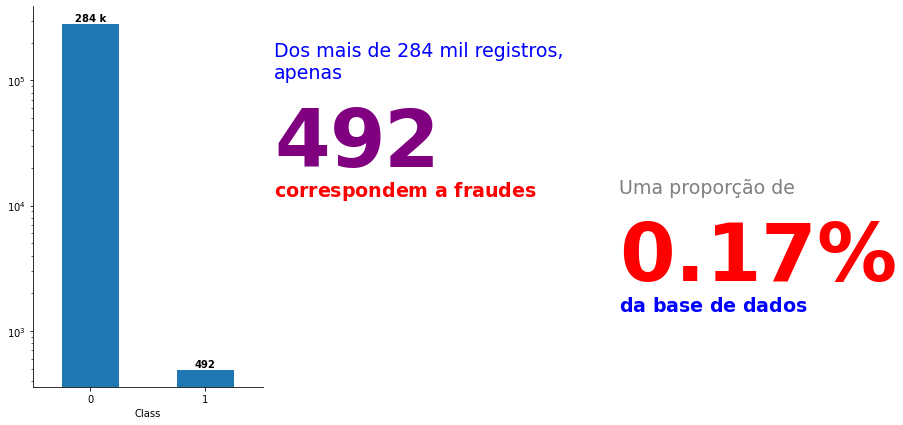

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(14, 7))

for ax in (ax2, ax3):
    ax.axis('off')

eng_format = EngFormatter(places=0)    
labels = df.groupby('Class').size().values

temp = df.groupby('Class')['Class'].size()

temp.plot(kind='bar', ax=ax1)

ax1.yaxis.set_major_formatter(EngFormatter())
ax1.set_yscale('log')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelrotation=0)

ax1.bar_label(ax1.containers[0], label_type='edge', 
              labels=map(eng_format, labels), color='black', fontsize=10, 
              weight='bold')

ax2.text(-0.15, 0.81,
         'Dos mais de 284 mil registros, \napenas',
         fontsize=19,
         color='blue')

ax2.text(-0.15, 0.58,
         r'$\bf{492}$', 
         fontsize=80,
         color='purple')

ax2.text(-0.15, 0.5,
         # use mathtext \\bf for bold text
         r'$\mathrm{\bf{correspondem\ a\ fraudes}}$',
         fontsize=19,
         color='red')

ax3.text(0.15, 0.51,
         'Uma proporção de',
         fontsize=19,
         color='gray')

ax3.text(0.15, 0.28,
         r'$\mathrm{\bf{0.17\%}}$', 
         fontsize=80,
         color='red')

ax3.text(0.15, 0.2,
         # use mathtext \\bf for bold text
         r'$\mathrm{\bf{da\ base\ de\ dados}}$',
         fontsize=19,
         color='blue')


plt.show()

### Visualizando a distribuição de cada variável

Vamos agora avaliar a distribuição de cada variável graficamente. Para iniciar, vamos estabelecer algumas configurações básicas para nossos gráficos:

In [13]:
params = {
    'lines.linewidth': 2.0,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.autolayout': True,
    'figure.titlesize': 14,    
    'figure.figsize': (8, 6),
    'legend.shadow': False,    
    'legend.fontsize': 8,
}

plt.rcParams.update(params)

Comecemos com histogramas para as variáveis do dataset:

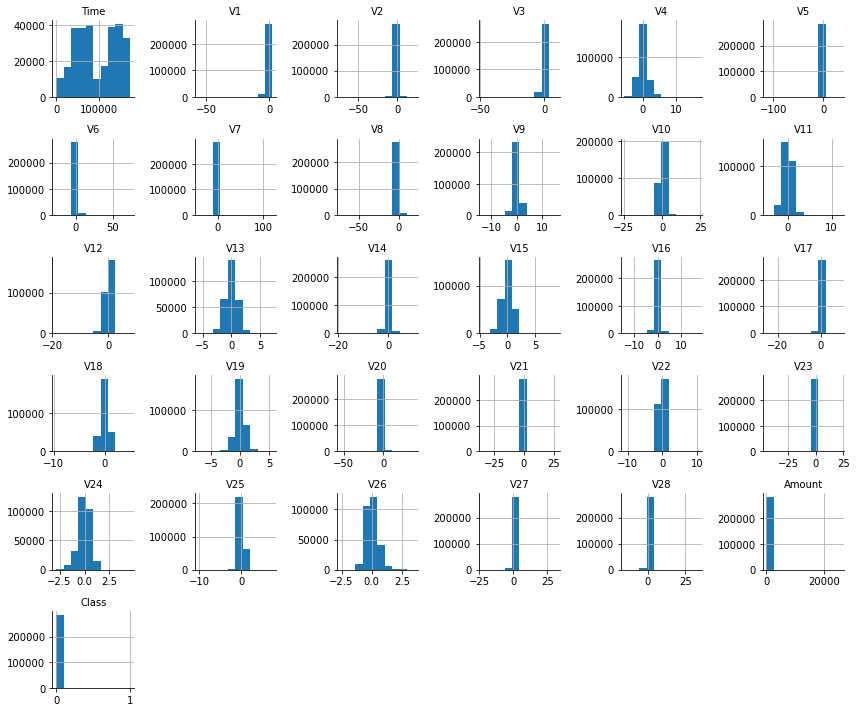

In [14]:
df.hist(figsize=(12, 10));

Vemos que todas as features `Vx` possuem valores centrados em zero, uma característica derivada do processo de PCA que as originou. 

A variável `Time` possui um perfil bimodal. Conforme citado anteriormente, o dataset é para transações de dois dias seguidos, sendo 0 o tempo inicial e os demais tempos registrados como o tempo, em segundos, entre cada transação após o momento inicial. Vemos que a primeira "onda" do perfil termina ao redor de 90.000 segundos, aproximadamente 25 h. Assim, considerando que o tempo zero seja meia-noite, o perfil bimodal é coerente com um maior registro de transações em horário comercial em cada dia.

Quanto a `Amount`, vemos uma única barra em valores pequenos. Coerente com o já discutido de que há grande concentração em valores abaixo de 100.00. 

Em `Class`, o já discutido predomínio do valor 0 referente a transações legítimas.

Vamos avaliar agora os *boxplots* de cada variável:

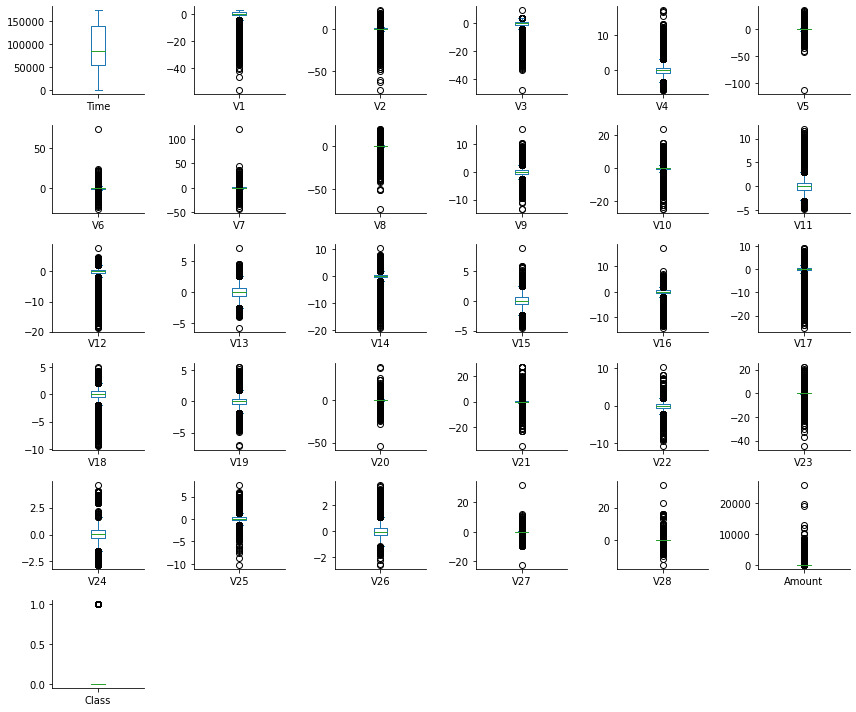

In [15]:
df.plot(kind='box', subplots=True, layout=(6, 6), 
        sharex=False, figsize=(12, 10));

Novamente, vemos que as features `Vx` estão centradas em zero mas, agora, é possível ver que possuem faixas de valores bem distintas e diversos outliers. Quanto a `Amount`, mais uma indicação que possui outliers em valores elevados.

As variáveis `Vx` são resultado de PCA e não temos informações sobre as variáveis originais. Assim, vamos avaliar como é a distribuição de cada classe alvo para cada variável. O intuito é tentar identificar quais dessas variáveis podem ser interessantes se em algum momento do estudo desejarmos selecionar features para melhorar nossos modelos. Usaremos [gráficos KDE](https://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde):

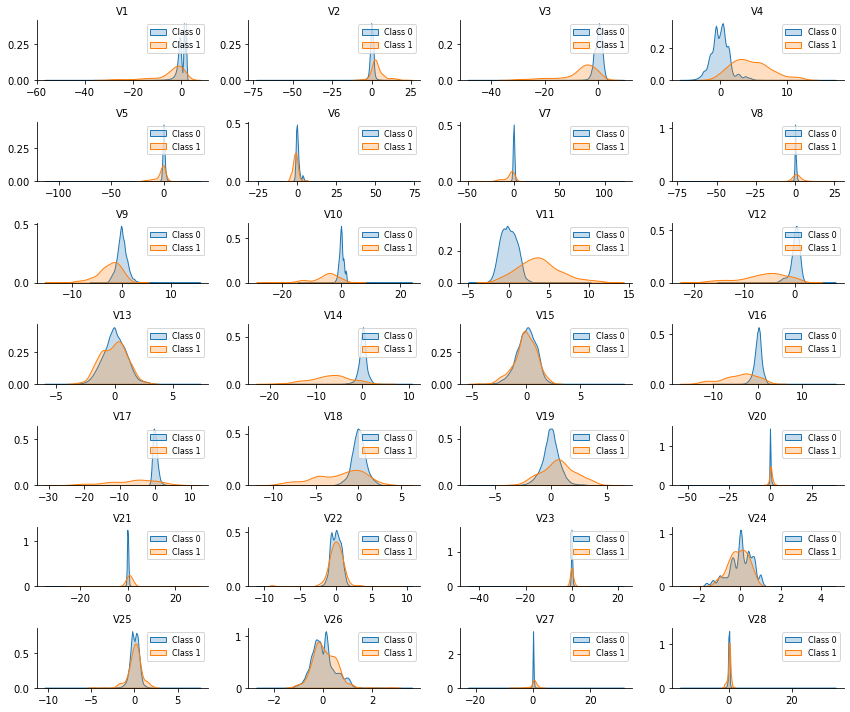

In [16]:
features = df.drop(['Time', 'Amount', 'Class'], axis=1).columns

df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(12, 10))

for axis, feature in zip(ax.flatten(), features):
    sns.kdeplot(df_class_0[feature], label='Class 0', shade=True, 
                ax=axis)
    sns.kdeplot(df_class_1[feature], label='Class 1', shade=True, 
                ax=axis)
    axis.set_title(feature)
    axis.set_xlabel(None)
    axis.set_ylabel(None)
    axis.legend()

Vemos que há variáveis onde a distinção das duas classes é bem clara: *V1-4*, *V9-12, V14*, e *V16-19*. Logo, podem ser de interesse em modelos. Mais adiante analisaremos diagramas de correlação que podem ratificar a escolha de tais variáveis.

Vejamos como é o comportamento de cada classe para a variável `Amount`:

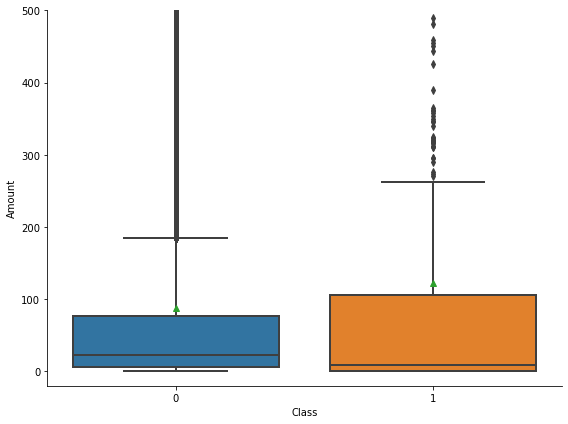

In [17]:
fig, ax = plt.subplots(sharex=True)

sns.boxplot(x=df['Class'], y=df['Amount'], showmeans=True, ax=ax)
ax.set_ylim((-20, 500))
plt.show()

Vemos que a mediana dos valores fraudulentos é menor que a de transações genuínas, embora a média seja maior. Vejamos um breve resumo estatístico das transações fraudulentas:

In [18]:
df[(df['Class'] == 1)]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Vemos que o valor máximo é de 2125.87, a média de 122.21, e a mediana de 9.25.

### Matriz de correlação

Vamos verificar a matriz de correlação entre as features de nosso dataset:

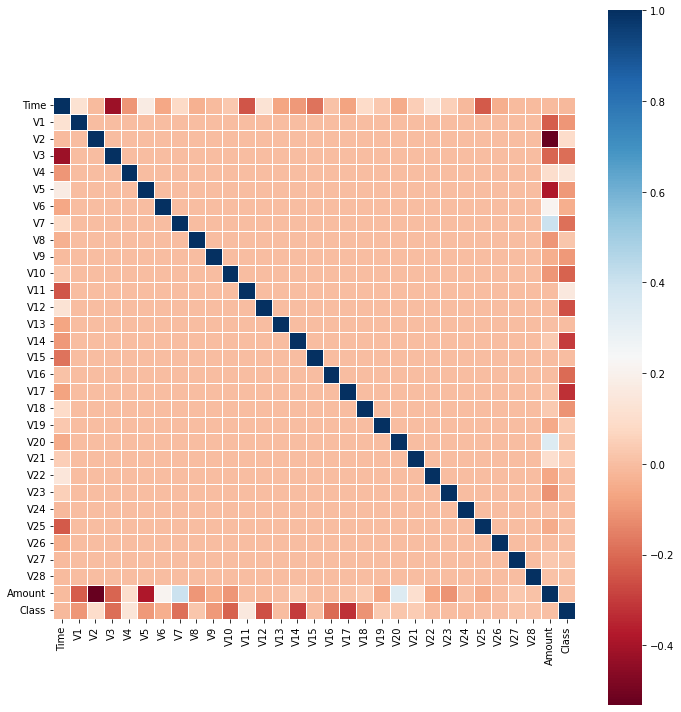

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(df.corr(), square=True, annot=False, fmt='.1f',
                 linecolor='white', linewidth=0.5, cmap='RdBu',);

plt.show()

Veja que é uma matrix que não faz muito sentido. Basicamente, informa que não há correlação alguma (nem positiva nem negativa) entre todas as variáveis `Vx`. Na realidade, isto é consequência do desbalanceamento da base de dados. Como quase todos os registros são de classe 0, transações legítimas, não são detectadas correlações.

Nosso próximo passo será preparar os dados para lidar com esse desbalanceamento.

## Preparando os dados

<center>
    <img alt="data" src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/data.jpg">
</center>

### Escalando os dados

Como já discutivo, as features `Amount` e `Time` não passaram por nenhum tipo de tratamento antes da disponibilização dos dados. Para alguns algoritmos como, por exemplo, o K-Nearest Neighbor (KNN), é interessante que os atributos tenham escalas similares. Há [diversos métodos para escalar os atributos](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html). Aqui, usaremos o `RobustScaler` por ser menos sensível a outliers muito discrepantes como os que ocorrem em `Amount`:

In [20]:
rob_scaler = RobustScaler()

amount_reshape = df['Amount'].values.reshape(-1,1)
time_reshape = df['Time'].values.reshape(-1,1)

df['scaled_amount'] = rob_scaler.fit_transform(amount_reshape)
df['scaled_time'] = rob_scaler.fit_transform(time_reshape)

df_scaled = df.drop(['Time','Amount'], axis=1)

with pd.option_context('precision', 2, 'display.max_columns', 50):
    display(df_scaled.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-1.83e-02,2.78e-01,-0.11,0.07,0.13,-0.19,1.34e-01,-0.02,0,1.78,-0.99
1,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-2.26e-01,-6.39e-01,0.10,-0.34,0.17,0.13,-8.98e-03,0.01,0,-0.27,-0.99
2,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,2.48e-01,7.72e-01,0.91,-0.69,-0.33,-0.14,-5.54e-02,-0.06,0,4.98,-0.99
3,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-1.08e-01,5.27e-03,-0.19,-1.18,0.65,-0.22,6.27e-02,0.06,0,1.42,-0.99
4,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-9.43e-03,7.98e-01,-0.14,0.14,-0.21,0.50,2.19e-01,0.22,0,0.67,-0.99


### Dividindo o dataset (treino e teste)

Para facilitar a reprodutibilidade deste estudo, em métodos que possuem parâmetros para controlar a semente de geração randômica, a seguinte semente será utilizada:

In [21]:
RANDOM_STATE = 42

Em bases de dados com grande desbalanço na classe alvo, como o caso, é importante que a porção da base separada para treino dos modelos tenha a mesma proporção entre as classes da porção separada para teste. Em um primeiro momento, vamos fazer uma simples divisão com o método `train_test_split` passando ao parâmetro `stratify` a variável alvo para que a divisão seja feita com a proporção desta variável:

In [22]:
X = df_scaled.drop('Class', axis=1)
y = df_scaled['Class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

Temos, então, pelas configurações padrão do método, 75 % do dataset separado para treino e os 25 % restantes, para teste:

In [23]:
print(f'{np.bincount(y_train)} {np.bincount(y_test)}')

[213236    369] [71079   123]


Vamos verificar que ambas as porções possuem o mesmo desbalanceamento:

In [24]:
print(f'{np.bincount(y_train) / sum(np.bincount(y_train)) * 100}')
print(f'{np.bincount(y_test)  / sum(np.bincount(y_test)) * 100}')

[99.82725123  0.17274877]
[99.82725204  0.17274796]


### Balanceando o dataset

Como vimos na matriz de correlação construída anteriormente, o desbalanceamento pode ser prejudicial para visualizar variáveis importantes e alguns algoritmos podem ter sua performance prejudicada com dados desbalanceados. Existem várias estratégias para lidar com esse problema:

- Reestruturar os dados:
    - Undersampling: reduzir o número de observações da classe majoritária para diminuir a diferença entre as categorias
    - Oversampling: criar sinteticamente novas observações da classe minoritária, igualando a proporção das categorias
- Utilizar um algoritmo mais resistente a problemas de desbalanceamento
- Se possível, coletar mais dados
- Usar modelos penalizados, ou seja, que penalizem mais erros de classificação da categoria minoritária
- Selecionar cuidadosamente a métrica de treino, selecionando uma que avalie mais cuidadosamente erros da classe minoritária

A única estratégia que não temos como adotar nesse estudo é a coleta de mais dados, é um dataset estático fornecido. Todas as demais estratégias terão participação neste estudo. Comecemos, então, pela reestruturação dos dados.

Temos um dataset de tamanho significativo de forma que adotar a estratégia de *undersampling* pode ser interessante. Dentre as técnicas de undersampling, a utilizada neste estudo será a retirada aleatória de dados da classe majoritária, a *Random Undersampling*, através do `RandomUnderSampler` da bibliotecada Imbalanced-Learning.

0    369
1    369
Name: Class, dtype: int64


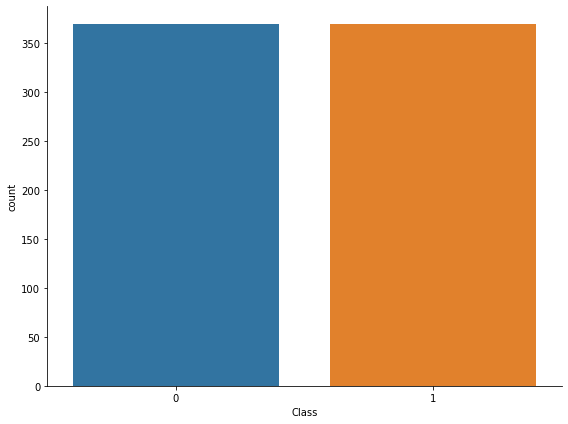

In [25]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)

X_rus, y_rus = rus.fit_resample(X_train, y_train)

print(y_rus.value_counts())

sns.countplot(x=y_rus);

Observe que o undersampling é realizado apenas na base de treino, gerando uma variável alvo que contém iguais quantidades. Vamos gerar um dataset com esses dados balanceados e analisá-lo:

In [26]:
df_balanced = pd.concat([X_rus, y_rus], axis=1)

df_balanced.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time,Class
0,-0.245994,0.864456,0.138314,-0.627707,0.440627,-1.072989,0.941862,-0.239466,0.197495,-0.168526,...,-0.640062,0.139061,-0.135690,-0.494629,0.127075,-0.017464,0.087222,-0.269825,0.765246,0
1,2.169390,-0.874467,-1.661547,-0.993435,-0.218378,0.253062,-1.196605,0.260048,0.130298,0.290238,...,0.530401,0.028349,-0.505492,-0.098210,-0.066314,0.010599,-0.029377,-0.055893,0.787028,0
2,-1.466046,0.946201,-1.508302,-0.918113,2.266431,0.770354,0.767603,0.618772,-0.806902,-0.968734,...,0.534899,-0.426521,-0.988301,0.270773,0.762529,-0.492720,0.112220,-0.167819,0.597657,0
3,-0.777055,-0.117475,0.723841,-3.492441,-0.052029,0.571674,-0.439675,-0.503063,-2.027951,0.902438,...,-0.705686,-0.395879,-0.442375,0.853427,-0.076788,0.281768,0.090274,-0.167680,0.592183,0
4,1.308457,-1.176200,-0.022869,-1.397037,-1.222895,-0.639747,-0.643778,-0.054389,-2.277189,1.584824,...,-0.995555,0.148532,0.143905,0.140944,-0.453468,-0.005713,0.013661,0.878921,-0.359649,0


In [27]:
df_balanced.shape

(738, 31)

#### Matriz de correlação e principais features

Vejamos como é a matriz de correlação deste novo dataset:

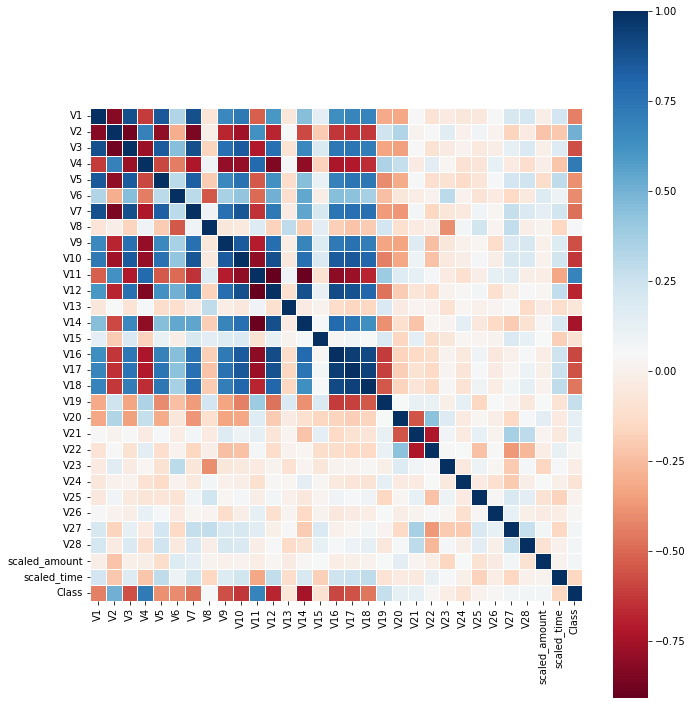

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(df_balanced.corr(), square=True, annot=False, fmt='.1f',
                 linecolor='white', linewidth=0.5, cmap='RdBu',);

plt.show()

Agora temos uma matriz de correlação usual. Vemos que há várias features que se correlacionam entre si, positiva ou negativamente, e conseguimos identificar como cada feature se correlaciona com nossa variável alvo. Vamos separar as features entre as que se correlacionam positivamente e as que se correlacionam negativamente com a variável alvo:

In [29]:
class_corr = df_balanced.corr()['Class']
class_corr.loc[lambda value: value < 0].sort_values()

V14           -0.749573
V12           -0.682799
V10           -0.632799
V16           -0.587845
V9            -0.571227
V3            -0.569337
V17           -0.561425
V7            -0.478392
V18           -0.466059
V1            -0.436271
V6            -0.407284
V5            -0.390976
scaled_time   -0.148974
V15           -0.090455
V24           -0.081980
V13           -0.069750
V23           -0.027070
Name: Class, dtype: float64

In [30]:
class_corr.loc[lambda value: value > 0].sort_values(ascending=False)

Class            1.000000
V4               0.719943
V11              0.685746
V2               0.503553
V19              0.276873
V20              0.132063
V21              0.129718
scaled_amount    0.075594
V27              0.073456
V28              0.071199
V8               0.060089
V26              0.038927
V22              0.035328
V25              0.008493
Name: Class, dtype: float64

Apenas para visualização e melhor compreensão, selecionemos as 4 features com maior correlação negativa e as 4 com maior correlação positiva:

- Negativa: V10, V12, V14, V16
- Positiva: V2, V4, V11, V19

Vejamos os diagramas *boxplot* dessas features separando as classes de transações:

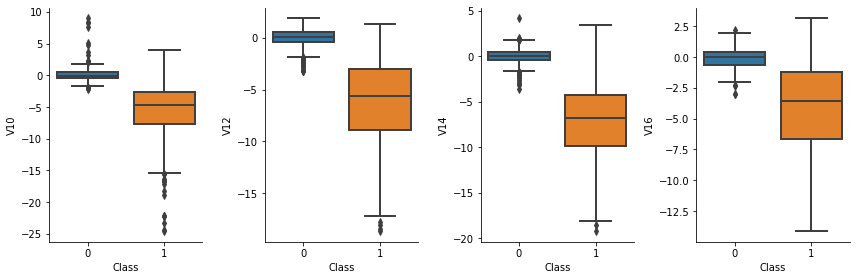

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

features_neg_corr = ('V10', 'V12', 'V14', 'V16')

for ax, feature in enumerate(features_neg_corr):
    sns.boxplot(x='Class', y=feature, data=df_balanced, ax=axes[ax])
    
plt.show()

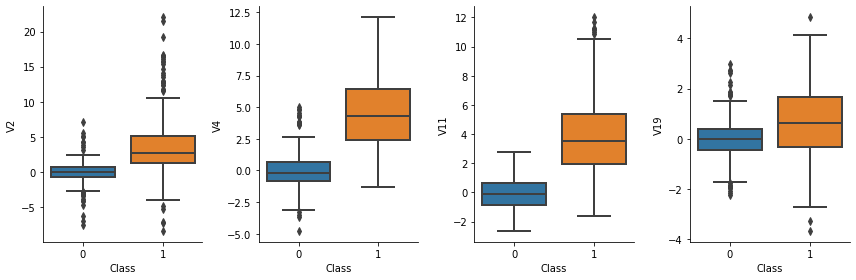

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

features_pos_corr = ('V2', 'V4', 'V11', 'V19')

for ax, feature in enumerate(features_pos_corr):
    sns.boxplot(x='Class', y=feature, data=df_balanced, ax=axes[ax])
    
plt.show()

Observe que, nas features de correlação negativa com a feature alvo, temos que a faixa de valores das transações fraudulentas é menor que a de transações genuínas. O contrário é observado para as features com correlação positiva.

Assim, caso no decorrer do estudo se resolva focar em algumas features já sabemos quais parecem as mais relevantes. Esse conhecimento pode ser útil, por exemplo, para fazer uma limpeza de outliers nessas features e verificar se há melhora nos modelos.

Como o *random undersampling* retira amostras aleatórias do dataset original, vejamos se o mesmo perfil de comportamento se observa para estas features no dataset original:

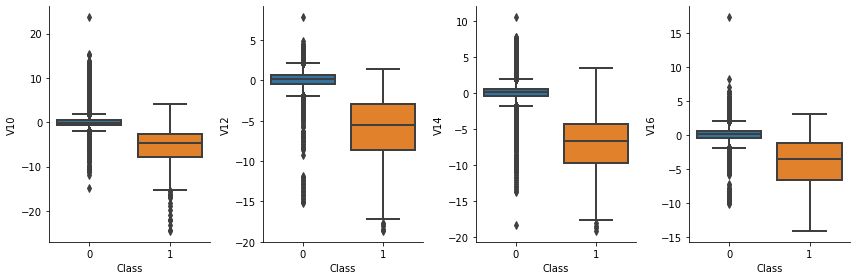

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

features_neg_corr = ('V10', 'V12', 'V14', 'V16')

for ax, feature in enumerate(features_neg_corr):
    sns.boxplot(x='Class', y=feature, data=df_scaled, ax=axes[ax])
    
plt.show()

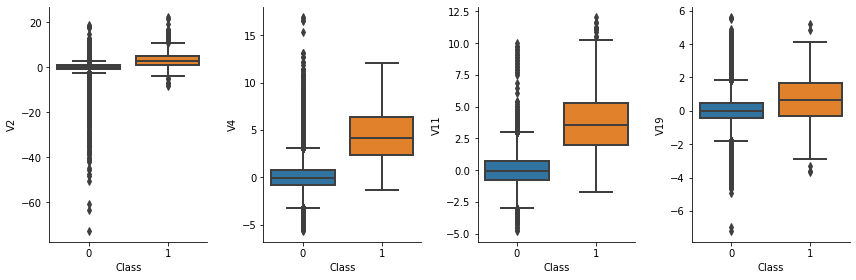

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

features_pos_corr = ('V2', 'V4', 'V11', 'V19')

for ax, feature in enumerate(features_pos_corr):
    sns.boxplot(x='Class', y=feature, data=df_scaled, ax=axes[ax])
    
plt.show()

Observa-se o mesmo comportamento.

Comecemos, então, a treinar modelos.

## Avaliando modelos

<center>
    <img alt="ai" src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/ai.jpg">
</center>

### Um pouco sobre métricas

Quando falamos de modelos, sempre surge a discussão de qual ou quais métricas serão consideradas para avaliar a performance comparativa de modelos para um determinado contexto. A [documentação do Scikit-Learn](https://scikit-learn.org/stable/modules/model_evaluation.html) possui muitas informações sobre o assunto e a Wikipedia possui [um artigo apenas para métricas de classificações binárias](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers). Aqui, vamos abordar o mínimo necessário para entender a escolha de métrica feita no estudo.

#### Matriz de confusão

Comecemos lembrando de uma matriz de confusão binária e de algumas terminologias importantes:

<center>
    <img alt="cm" src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/confusion_matrix.png">
</center>

#### Acurácia

A métrica mais famosa, e, talvez, a mais erroneamente utilizada, é a **acurácia**. Para uma classificação binária:

$$
\text{acurácia} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Veja, pela definição acima, que é uma métrica que considera a fração de acertos no total de predições. Logo, se a base de dados for muito desbalanceada, como no nosso caso onde mais 99 % das entradas são de uma das classes, altas acurácias serão obtidas facilmente. Afinal, basta prever que todas as entradas são da classe dominante e já teremos acurácias da ordem de 99 %. Caso tenha ficado com dúvidas, veja [este artigo sobre o paradoxo da acurácia](https://en.wikipedia.org/wiki/Accuracy_paradox), que é o nome deste fenômeno. Veremos isto na prática mais adiante neste estudo.

#### Precisão e recall

Em situações desbalanceadas, duas outras métricas costumam ser usadas no lugar da acurácia, a **precisão** e o **recall**, com as seguintes definições:

$$
\text{precisão} = \frac{TP}{TP + FP} \qquad \text{recall} = \frac{TP}{TP + FN}
$$

Vemos que a precisão é a fração de verdadeiros positivos frente o total de previsões positivas. Ou seja, quanto seu modelo é bom em prever positivos. Buscar maximizar a precisão irá minimizar o número de erros de falsos positivos.

Já o recall é fração de verdadeiros positivos frente ao total de positivos reais. Afinal, os falsos negativos são, na realidade, positivos. Logo, o recall quantifica a proporção de reais positivos que foram identificados. Buscar maximizar o recall irá minimizar o número de erros de falsos negativos.

Considere nosso contexto de fraude em cartões de crédito. Ao classificar erroneamente uma transação fraudulenta como legítima, um usuário teve seu dinheiro roubado via, por exemplo, clonagem do cartão. A compania do cartão terá que reembolsar o usuário. Por outro lado, uma transação legítima ser considerada fraudulenta significa que o usuário terá seu cartão bloqueado indevidamente, causando conflito e desconforto no cliente.

#### F-measure

Observe que há um *trade-off* entre essas duas métricas. Uma busca por aumentar a precisão pode diminuir o recall e vice-versa. Assim, há uma métrica, a **F-measure** (medida F), que é a média harmônica entre precisão e recall:

$$
\text{F-measure} = \frac{2 \times \text{precisão} \times \text{recall}}{\text{precisão} + \text{recall}}
$$

#### AUROC

Podemos avaliar este trade-off por outras métricas. O recall também é chamado de *TPR - true positive rate* (taxa de verdadeiros positivos). Há, também, a chamada *FPR - false positive rate* (taxa de falsos positivos) definida por:

$$
\text{FPR} = \frac{FP}{TN + FP}
$$

Com estas duas definições, podemos construir um gráfico de **Receiver Operating Characteristics (ROC)** ou, em português, Curva Característica de Operação do Receptor. Tal curva, para um dado modelo de classificação binária, mostra o trade-off de tal modelo entre benefícios (verdadeiros positivos) e custos (falsos positivos):

<img alt='ROC curves' src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/Curva_ROC.svg/640px-Curva_ROC.svg.png'>

<center>    
    <p style="font-size:80%;color:gray">Curva ROC. <a href="https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor">Fonte.</a></p>
</center>

A métrica utilizada para comparar diferentes modelos é a área sob a curva (**AUC - area under the curve**),  daí ser comum a sigla AUROC.

<img alt='AUC' src='https://paulvanderlaken.files.wordpress.com/2019/08/95971-1pk05qgzowhcgriifbz-okq.png'>

<center>    
    <p style="font-size:80%;color:gray">Área sob a curva (AUC). <a href="https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5">Fonte.</a></p>
</center>

Na animação abaixo, vemos o comportamento de um modelo. Veja como a busta por mais verdadeiros positivos aumenta a taxa de falsos positivos e como a busca por diminuir falsos positivos leva à diminuição de verdadeiros positivos.

<img alt='AUC cutoff' src='https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/cutoff.gif'>

<center>    
    <p style="font-size:80%;color:gray">AUROC e distribuições das classes. <a href="https://github.com/dariyasydykova/open_projects">Fonte.</a></p>
</center>

O formato da curva ROC muda de acordo com a capacidade que o  modelo tem de classificar corretamente cada classe. A animação a seguir começa com as distribuições de cada classe sobrepostas, ou seja, o modelo não consegue distinguir as classes. Nessa situação AUC = 0.5, equivalente à um classificador aleatório ("um chute"). À medida que o modelo consegue separar mais as classes, AUC aumenta até a classificação perfeita onde AUC = 1, onde a curva forma um ângulo reto.

<img alt='AUC sep' src='https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/ROC.gif'>

<center>    
    <p style="font-size:80%;color:gray">AUROC e capacidade de distinção de classes do modelo. <a href="https://github.com/dariyasydykova/open_projects">Fonte.</a></p>
</center>

#### AUPRC

A AUROC é uma métrica bastante utilizada, especialmente com a finalidade já citada de selecionar modelos que maximizem a área. No entanto, [trabalhos na literatura](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432) demonstram que há uma métrica melhor para datasets desbalanceados como o que estamos estudando aqui.

Já vimos as definições de precisão e de recall e como há um trade-off na busca por melhorar um ou outro. Isto também pode ser representado graficamente gerando uma curva e calculando a área sob esta curva. É a **AUPRC** (area under precision-recall curve). Vejamos como a AUROC e a AUPRC se comportam com a mudança na capacidade de um modelo de identificar bem duas classes na animação a seguir:

<img alt='AUC PR' src='https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/PR.gif'>

<center>    
    <p style="font-size:80%;color:gray">AUROC vs AUPRC e capacidade de distinção de classes do modelo. <a href="https://github.com/dariyasydykova/open_projects">Fonte.</a></p>
</center>

Veja que as duas curvas respondem significativamente a mudanças na capacidade de classificação.

Agora, observe as animações a seguir:

<img alt='AUPRC imb1' src='https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/imbalance.gif'>

<img alt='AUPRC imb2' src='https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/imbalance2.gif'>

<center>    
    <p style="font-size:80%;color:gray">AUROC vs AUPRC em bases de dados desbalanceadas. <a href="https://github.com/dariyasydykova/open_projects">Fonte.</a></p>
</center>

Vemos nas duas animações o efeito de um grande desbalanceamento entre as classes. Veja que a AUROC permanece quase inalterada, pois o formato da curva ROC quase não se altera. Já o formato da PRC muda bastante e, consequentemente, a AUPRC. Não por acaso, a [página do dataset no Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) recomenda o uso da AUPRC.

#### Nossos objetivos

Portanto, tendo em vista o discutido anteriormente:

> Usaremos a AUPRC para selecionar os modelos mais promissores

> Após a seleção, faremos um estudo de otimização de hiperparâmetros para tais modelos

> Em tal otimização, avaliaremos o resultado de uma busca por maiores AUPRC e faremos a comparação com uma busca por maiores valores de recall

Precisamos de uma função que possa calcular a AUPRC, já que não há nativamente no Scikit-Learn:

In [35]:
def pr_auc(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    return auc(recall, precision)

Vamos criar um dicionário com as métricas discutidas nesta seção. Embora já saibamos quais são relevantes no nosso contexto, vamos comparar os valores para ter uma visão mais completa do nosso problema.

In [36]:
scoring = {
    'accuracy' : make_scorer(accuracy_score), 
    'precision' : make_scorer(precision_score),
    'recall' : make_scorer(recall_score), 
    'f1_score' : make_scorer(f1_score),
    'auprc': make_scorer(pr_auc, needs_proba=True),
    'auroc': make_scorer(roc_auc_score),       
           }

### Definindo uma referência de performance

Vamos criar um *baseline*, uma referência, para nossa avaliação. Assim, sabemos que modelos que têm desempenho menor que nossa referência podem ser descartados.

Para criar nossa referência, usaremos a classe `DummyClassifier` do Scikit-Learn com a estratégia `constant`, recomendada como referência para classificadores que buscam ter boa performance em classes minoritárias [segundo a documentação](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). Já vimos, na parte de preparo de dados de nosso estudo, que devemos usar estratégias estratificadas para que treino e teste tenham a mesma proporção entre as classes. Usamos, então, o `RepeatedStratifiedKFold` para fazer diversos splits (divisões) treino/teste e `cross_validate` para retornar o resultado consolidado de todas os splits por validação cruzada:

In [37]:
dummy_model = DummyClassifier(strategy='constant', constant=1)

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

scores = cross_validate(dummy_model, X, y, scoring=scoring, cv=rskf, n_jobs=-2)

In [38]:
print('{0:^15} | {1:^10} | {2:^10}'.format('Metric', 'Mean', 'Std Dev'))
print('-' * 40)

for key, _ in scoring.items():
    metric = ''.join(('test_', key))
    mean = np.mean(scores[metric])
    std_dev = np.std(scores[metric])
    print('{0:<15} | {1:^10.3f} | {2:^10.3f}'.format(key, mean, std_dev))

    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.002    |   0.000   
precision       |   0.002    |   0.000   
recall          |   1.000    |   0.000   
f1_score        |   0.003    |   0.000   
auprc           |   0.501    |   0.000   
auroc           |   0.500    |   0.000   


Veja que o `auprc`, que representa o AUPRC visto anteriormente, retornou valor 0.5. Ou seja, se comportou como um classificador aleatório. Escolheremos classificadores que se comportem melhor que este baseline.

### Aplicando no dataset completo

Discutimos anteriormente que há potenciais ganhos em adotar estratégias de balanceamento de dataset quando temos casos onde uma das classes é muito menor que outra. Vamos, portanto, treinar alguns modelos no dataset completo, ou seja, desbalanceado, para que os resultados sirvam de base de comparação para os resultados que obteremos mais adiante com estratégias de balanceamento.

Para esse estudo, analisaremos seis algoritmos de classificação:

- Algoritmos lineares:
    - Regressão logística (*Logistic Regression* - LR)
    - Análise de discriminante linear (*Linear Discriminat Analysis* - LDA)
- Algorimos não lineares:
    - k vizinhos mais próximos (*k-Nearest Neighbors* - KNN)
    - *Naive Bayes* - NB
    - Árvore de decisão (*Classification and Regression Trees* - CART)
    - Máquina de vetores de suporte (*Support Vector Machines* - SVM)

Para o dataset completo, que possui mais de 280 mil entradas, não utilizaremos o KNN nem o SVM por serem algoritmos que demandam elevada potência computacional em grandes datasets. Os utilizaremos mais adiante, quando adotarmos estratégias de undersampling. Comecemos colocando nossos modelos em uma lista:

In [39]:
models = []
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

Vamos criar uma função que possa receber as features, a variável alvo e um modelo, e retornar o resultado consolidado para cada métrica:

In [40]:
def evaluate_model(X, y, model):
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
    scores = cross_validate(model, X, y, scoring=scoring, cv=rskf, n_jobs=-2)
    return scores

E, agora, apresentar os resultados:

In [41]:
results = []
names = []

for name, model in models:
    names.append(name)
    scores = evaluate_model(X, y, model)
    results.append(scores)
    
for name, result in zip(names, results):
    print(name)
    print('{0:^15} | {1:^10} | {2:^10}'.format('Metric', 'Mean', 'Std Dev'))
    print('-' * 40)
    for key in scoring.keys():
        metric = ''.join(('test_', key))
        mean = np.mean(result[metric])
        std_dev = np.std(result[metric])    
        print('{0:<15} | {1:^10.3f} | {2:^10.3f}'.format(key, mean, std_dev))
    print()

LR
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.999    |   0.000   
precision       |   0.875    |   0.034   
recall          |   0.624    |   0.044   
f1_score        |   0.727    |   0.027   
auprc           |   0.758    |   0.024   
auroc           |   0.812    |   0.022   

LDA
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.999    |   0.000   
precision       |   0.866    |   0.026   
recall          |   0.766    |   0.018   
f1_score        |   0.812    |   0.013   
auprc           |   0.782    |   0.025   
auroc           |   0.883    |   0.009   

CART
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.999    |   0.000   
precision       |   0.753    |   0.029   
recall          |   0.759    |   0.030   
f1_score        |   0.755    |   0.021   
auprc           |   0.756    |   0.020   
auroc           |   0.8

Veja que todos os modelos obtiveram resultados de acurácia muito altos. Isto corrobora o discutido anteriormente sobre o paradoxo da acurácia, mostrando porque tal métrica não é adequada com datasets desbalanceados.

Também vemos que os valores de AUROC de todos os modelos são elevados. No entanto, Naive Bayes, modelo com maior AUROC, possui o menor AUPRC. Inclusive, menor que nosso baseline. Vemos, aqui, a importância de utilizar métricas que sejam condizentes com o problema a ser resolvido.

É bastante comum representar os resultados de modelos de classificação binária na forma de matrizes de confusão. Como estamos fazendo uma estratégia de repetição, vamos criar uma função que retorne a média dos resultados das repetições:

In [42]:
def mean_confusion_matrices(X, y, model, normalize=None):
    rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
    cm_arrays = []
    
    for train_index, test_index in rsk.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        cm = confusion_matrix(y_test, model.predict(X_test), normalize=normalize)
        cm_arrays.append(cm)
    
    return np.mean(cm_arrays, axis=0)

Agora, criar as matrizes para cada modelo:

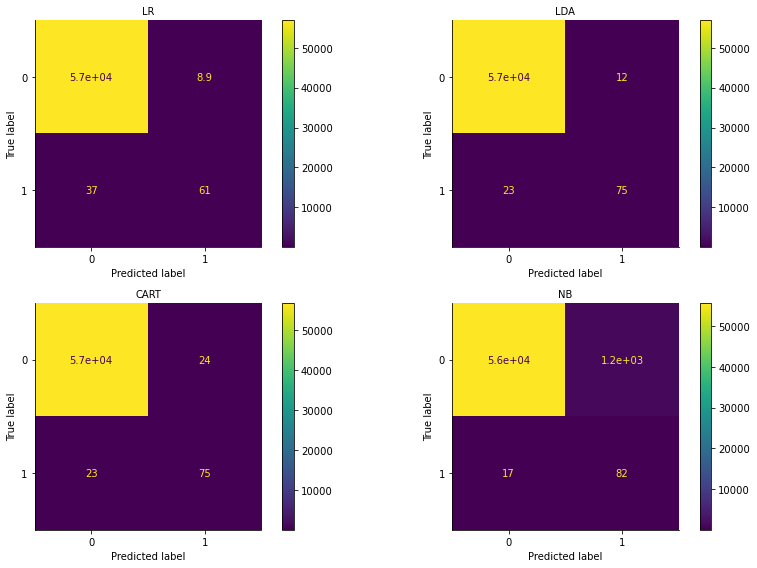

In [43]:
names = []
cm_means = []

for name, model in models:
    names.append(name)    
    cm_means.append(mean_confusion_matrices(X, y, model))
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for ax, name, matrix in zip(axes.flatten(), names, cm_means):
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax.set_title(name)

Veja como o modelo Naive Bayes tem um número muito maior de falsos positivos.

Vamos gerar as matrizes de confusão normalizadas para visualizar melhor as proporções. Nesse tipo de matriz, a soma de cada linha da matriz é 1:

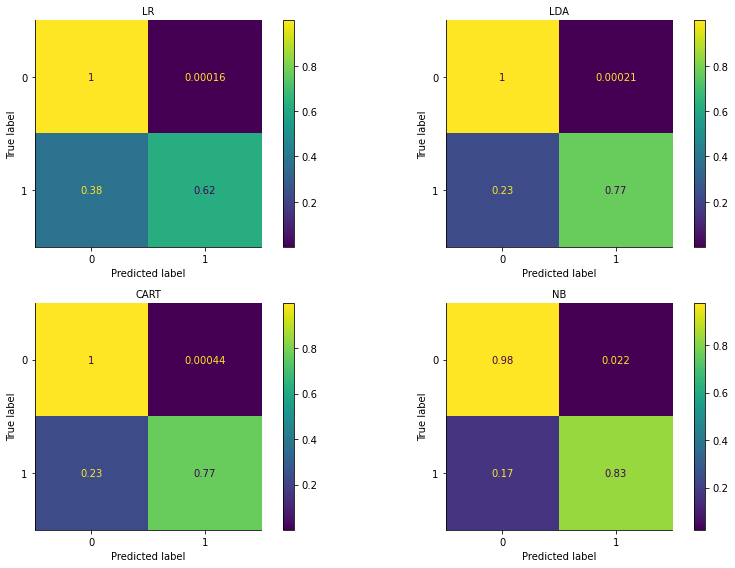

In [44]:
names = []
cm_means_norm = []

for name, model in models:
    names.append(name)    
    cm_means_norm.append(mean_confusion_matrices(X, y, model, normalize='true'))
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for ax, name, matrix in zip(axes.flatten(), names, cm_means_norm):
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax.set_title(name)

Acredito que essa forma de visualizar permite uma melhor comparação entre os modelos, permitindo compreender a proporção dos resultados. Perceba como o Naive Bayes foi o único que teve uma fração significativa de falsos positivos, o que levou ao seu menor valor de AUPRC comparado aos demais modelos.

### Aplicando undersampling

Vimos anteriormente que a estratégia de undersampling para balancear o dataset permitiu descobrir correlações entre variáveis. No entanto, fazer apenas uma divisão de treino/teste e aplicar o undersampling não é o ideal. O ideal, sempre que possível, é fazer várias divisões e avaliar o consolidado. Assim, precisamos aplicar o undersampling em cada divisão realizada. Para isso, usaremos a função a seguir na qual criamos um *pipeline* para utilizar o `RandomUnderSampler` do Imbalanced-Learn em cada divisão antes de se avaliar os modelos:

In [45]:
def evaluate_model_undersampling(X, y, model):
    steps = [('under', RandomUnderSampler(random_state=RANDOM_STATE)), 
             ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    # apenas 2 splits, pois temos poucas entradas para classe 1
    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=RANDOM_STATE)
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=rskf, n_jobs=-2)
    return scores

Agora, incluiremos os modelos KNN e SVM (SVC no Scikit-Learn, onde o "C" significa *classifier*) tendo em vista que estaremos com datasets menores:

In [46]:
models = []
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(probability=True)))

Vejamos os resultados:

In [47]:
results = []
names = []

for name, model in models:
    names.append(name)
    scores = evaluate_model_undersampling(X, y, model)
    results.append(scores)
    
for name, result in zip(names, results):
    print(name)
    print('{0:^15} | {1:^10} | {2:^10}'.format('Metric', 'Mean', 'Std Dev'))
    print('-' * 40)
    for key in scoring.keys():
        metric = ''.join(('test_', key))
        mean = np.mean(result[metric])
        std_dev = np.std(result[metric])    
        print('{0:<15} | {1:^10.3f} | {2:^10.3f}'.format(key, mean, std_dev))
    print()

LR
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.961    |   0.006   
precision       |   0.040    |   0.007   
recall          |   0.912    |   0.015   
f1_score        |   0.077    |   0.013   
auprc           |   0.578    |   0.100   
auroc           |   0.937    |   0.005   

LDA
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.980    |   0.004   
precision       |   0.070    |   0.014   
recall          |   0.839    |   0.017   
f1_score        |   0.129    |   0.024   
auprc           |   0.171    |   0.047   
auroc           |   0.910    |   0.007   

KNN
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.972    |   0.007   
precision       |   0.056    |   0.012   
recall          |   0.894    |   0.019   
f1_score        |   0.105    |   0.021   
auprc           |   0.601    |   0.065   
auroc           |   0.93

Agora, seguindo nossos objetivos, vamos selecionar os modelos com maior AUPRC:

In [48]:
models = []
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(probability=True)))

Vamos modificar nossa função de geração de matrizes de confusão para utilizar *undersampling*:

In [49]:
def mean_confusion_matrices_undersampling(X, y, model, normalize=None):
    rus = RandomUnderSampler(random_state=RANDOM_STATE)
    
    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=RANDOM_STATE)
    cm_arrays = []
    
    for train_index, test_index in rskf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_rus, y_rus = rus.fit_resample(X_train, y_train)
        model.fit(X_rus, y_rus)
        cm = confusion_matrix(y_test, model.predict(X_test), normalize=normalize)
        cm_arrays.append(cm)
    
    return np.mean(cm_arrays, axis=0)

Agora, podemos gerar as matrizes para os três modelos selecionados:

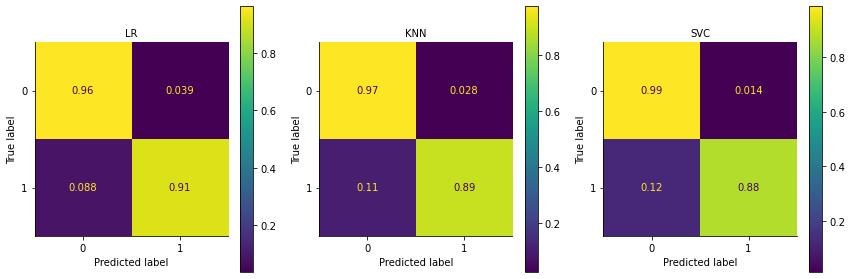

In [50]:
names = []
cm_means_norm = []

for name, model in models:
    names.append(name)    
    cm_means_norm.append(mean_confusion_matrices_undersampling(X, y, model, normalize='true'))
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ax, name, matrix in zip(axes.flatten(), names, cm_means_norm):
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax.set_title(name)

Veja que os três modelos escolhidos foram mais eficazes em prever os casos verdadeiros de fraude do que os modelos aplicados ao dataset completo. Ou seja, resultaram em maiores valores de recall. Em especial, a regressão logística, LR, conseguiu detectar mais casos verdadeiros de fraude do que o mesmo modelo aplicado ao dataset completo. No entanto, isto levou a um aumento de falsos positivos quando comparado ao mesmo modelo no dataset completo. Como já descrito anteriormente, este trade-off é uma constante neste tipo de análise.

## Otimizando os hiperparâmetros dos modelos escolhidos

<center>
    <img alt="" src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/performance.jpg">
</center>

Hiperparâmetros são parâmetros de modelos que devem ser definidos antes de treinar o modelo. Utilizaremos o `GridSearchCV` do Scikit-Learn que irá testar todas as combinações possíveis dos hiperparâmetros passados. Em seguida, retornará a combinação de hiperparâmetros que resultou em menor erro para a métrica escolhida.

Assim, primeiro precisamos criar uma função que irá performar a busca por esta combinação de hiperparâmetros:

In [51]:
def grid_search_undersampling(X, y, model, params, scoring='roc_auc'):
    rus = RandomUnderSampler(random_state=RANDOM_STATE)
    
    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=RANDOM_STATE)   
        
    for train_index, test_index in rskf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_rus, y_rus = rus.fit_resample(X_train, y_train)
        search = GridSearchCV(model, params, scoring=scoring)
        search.fit(X_rus, y_rus)
        
    return search.best_estimator_

Iremos fazer esta otimização com os três modelos escolhidos anteriormente. Para cada um deles, passaremos diversas opções de hiperparâmetros que serão exaustivamente combinadas entre si pelo `GridSearchCV`:

In [52]:
models = []

models.append(('LR', 
               LogisticRegression(max_iter=700),
               [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'class_weight': [None, 'balanced'],
                'penalty': ['l1'], 
                'solver': ['liblinear', 'saga']},
               {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'class_weight': [None, 'balanced'],
                'penalty': ['l2'], 
                'solver': ['lbfgs', 'newton-cg', 'sag']}]))

models.append(('KNN', 
               KNeighborsClassifier(),
               {'n_neighbors': list(range(2, 6, 1)), 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'weights': ['uniform', 'distance']}))

models.append(('SVC', 
               SVC(probability=True),
               {'C': [0.5, 0.7, 0.9, 1], 
                'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
                'class_weight': [None, 'balanced'],}))

### Métrica: AUPRC

O `GridSearchCV` retorna os melhores hiperparâmetros de acordo com alguma métrica. Como estamos discutindo desde o início deste estudo, a AUPRC é uma métrica que tem se mostrado mais adequada ao nosso contexto. Vejamos os melhores hiperparâmetros para cada modelo por essa métrica:

In [53]:
# Algumas combinações geram warnings que podem ser ignorados

results = []
names = []

for name, model, params in models:
    names.append(name)
    scores = grid_search_undersampling(X, y, model, params,
                                       scoring=make_scorer(pr_auc, needs_proba=True))
    results.append(scores)

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_mode

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

Esses são os resultados:

In [54]:
results

[LogisticRegression(C=0.001, max_iter=700),
 KNeighborsClassifier(),
 SVC(C=0.5, probability=True)]

Vamos, então, criar uma lista com nossos modelos configurados com estes hiperparâmetros otimizados:

In [55]:
models = []
models.append(('LR', LogisticRegression(max_iter=700, C=0.001)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(probability=True, C=0.5)))

Vejamos como tal otimização reflete em nossas métricas:

In [56]:
results = []
names = []

for name, model in models:
    names.append(name)
    scores = evaluate_model_undersampling(X, y, model)
    results.append(scores)

for name, result in zip(names, results):
    print(name)
    print('{0:^15} | {1:^10} | {2:^10}'.format('Metric', 'Mean', 'Std Dev'))
    print('-' * 40)
    for key in scoring.keys():
        metric = ''.join(('test_', key))
        mean = np.mean(result[metric])
        std_dev = np.std(result[metric])    
        print('{0:<15} | {1:^10.3f} | {2:^10.3f}'.format(key, mean, std_dev))
    print()

LR
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.998    |   0.000   
precision       |   0.479    |   0.067   
recall          |   0.825    |   0.004   
f1_score        |   0.603    |   0.053   
auprc           |   0.702    |   0.027   
auroc           |   0.911    |   0.002   

KNN
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.972    |   0.007   
precision       |   0.056    |   0.012   
recall          |   0.894    |   0.019   
f1_score        |   0.105    |   0.021   
auprc           |   0.601    |   0.065   
auroc           |   0.933    |   0.008   

SVC
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.989    |   0.002   
precision       |   0.124    |   0.018   
recall          |   0.859    |   0.009   
f1_score        |   0.217    |   0.027   
auprc           |   0.707    |   0.015   
auroc           |   0.92

Vemos que, efetivamente, os valores AUPRC para LR e SVC estão maiores do que antes da otimização. O KNN permanece inalterado pois a otimização resultou nos hiperparâmetros que já são utilizados por padrão no modelo. Vejamos isto em matrizes de confusão normalizadas:

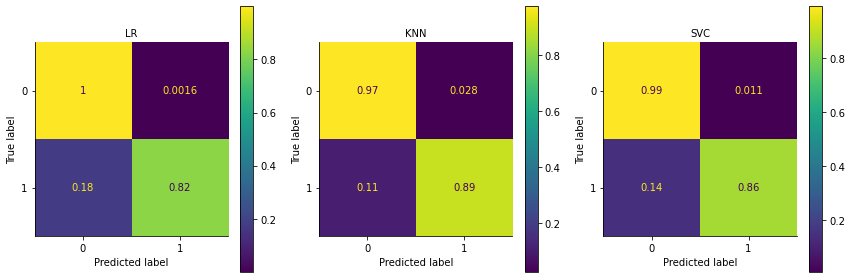

In [57]:
names = []
cm_means_norm = []

for name, model in models:
    names.append(name)    
    cm_means_norm.append(mean_confusion_matrices_undersampling(X, y, model, normalize='true'))
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ax, name, matrix in zip(axes.flatten(), names, cm_means_norm):
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax.set_title(name)

Conforme estamos discutindo durante todo o estudo, há um trade-off entre precisão e recall. Assim, para os modelos LR e SVC, o resultado foi um aumento da precisão e diminuição do recall, com a consequente diminuição dos falsos positivos e aumento dos falsos negativos.

Mas, e se escolhêssemos maximizar a detecção de casos de fraude?

### Métrica: recall

Muitos podem pensar que uma determinada instituição financeira iria buscar maximizar a detecção de fraude, ou seja, aumentar o recall minimizando os falsos negativos. Vejamos as consequências desta estratégia. Vamos, novamente, listar os hiperparâmetros que serão analisados pelo grid search:

In [58]:
models = []

models.append(('LR', 
               LogisticRegression(max_iter=700),
               [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'class_weight': [None, 'balanced'],
                'penalty': ['l1'], 
                'solver': ['liblinear', 'saga']},
               {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'class_weight': [None, 'balanced'],
                'penalty': ['l2'], 
                'solver': ['lbfgs', 'newton-cg', 'sag']}]))

models.append(('KNN', 
               KNeighborsClassifier(),
               {'n_neighbors': list(range(2, 6, 1)), 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'weights': ['uniform', 'distance']}))

models.append(('SVC', 
               SVC(probability=True),
               {'C': [0.5, 0.7, 0.9, 1], 
                'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
                'class_weight': [None, 'balanced'],}))

Passemos tais modelos para nossa função, alterando o parâmetro `scoring` para `recall`:

In [59]:
results = []
names = []

for name, model, params in models:
    names.append(name)
    scores = grid_search_undersampling(X, y, model, params, scoring='recall')
    results.append(scores)

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_mode

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_science/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/data_s

Eis nossos resultados:

In [60]:
results

[LogisticRegression(C=0.01, max_iter=700, penalty='l1', solver='liblinear'),
 KNeighborsClassifier(n_neighbors=2, weights='distance'),
 SVC(C=0.5, kernel='linear', probability=True)]

Vamos recriar nossos modelos com os hiperparâmetros otimizados e verificar as métricas obtidas:

In [61]:
models = []
models.append(('LR', LogisticRegression(max_iter=700, C=0.01, penalty='l1', solver='liblinear')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=2, weights='distance')))
models.append(('SVC', SVC(probability=True, C=0.5, kernel='linear',)))

In [62]:
results = []
names = []

for name, model in models:
    names.append(name)
    scores = evaluate_model_undersampling(X, y, model)
    results.append(scores)
    
for name, result in zip(names, results):
    print(name)
    print('{0:^15} | {1:^10} | {2:^10}'.format('Metric', 'Mean', 'Std Dev'))
    print('-' * 40)
    for key in scoring.keys():
        metric = ''.join(('test_', key))
        mean = np.mean(result[metric])
        std_dev = np.std(result[metric])    
        print('{0:<15} | {1:^10.3f} | {2:^10.3f}'.format(key, mean, std_dev))
    print()

LR
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.563    |   0.007   
precision       |   0.004    |   0.000   
recall          |   0.967    |   0.012   
f1_score        |   0.008    |   0.000   
auprc           |   0.681    |   0.020   
auroc           |   0.765    |   0.007   

KNN
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.932    |   0.007   
precision       |   0.023    |   0.002   
recall          |   0.919    |   0.014   
f1_score        |   0.045    |   0.004   
auprc           |   0.482    |   0.010   
auroc           |   0.926    |   0.004   

SVC
    Metric      |    Mean    |  Std Dev  
----------------------------------------
accuracy        |   0.963    |   0.008   
precision       |   0.043    |   0.008   
recall          |   0.914    |   0.014   
f1_score        |   0.081    |   0.014   
auprc           |   0.532    |   0.131   
auroc           |   0.93

Vemos que, efetivamente, os valores de recall aumentaram às custas de diminuição de precisão e de AUPRC. Vejamos as matrizes de confusão:

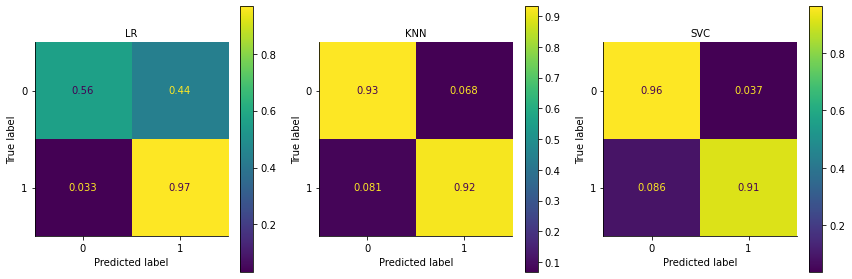

In [63]:
names = []
cm_means_norm = []

for name, model in models:
    names.append(name)    
    cm_means_norm.append(mean_confusion_matrices_undersampling(X, y, model, normalize='true'))
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ax, name, matrix in zip(axes.flatten(), names, cm_means_norm):
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax.set_title(name)

Observe que a regressão logística teve o maior valor de recall, mas o custo foi ter uma proporção significativa de falsos positivos. Seria este o cenário ideal? Os demais modelos também tiveram um aumento nos falsos positivos comparado ao cenário anterior onde maximizamos o AUPRC, mas em menor escala. O SVC possui a melhor precisão.

### Devemos maximizar o recall?

Ao classificar erroneamente uma transação fraudulenta como legítima, um usuário teve seu dinheiro roubado via, por exemplo, clonagem do cartão. A compania do cartão terá que reembolsar o usuário. Por outro lado, uma transação legítima ser considerada fraudulenta significa que o usuário terá seu cartão bloqueado indevidamente, causando conflito, constrangimento e desconforto no cliente.

Os dois cenários possuem custos distintos e o ideal seria fazer uma análise de valor esperado para cada modelo considerando tais custos. Não temos tais dados para o dataset em estudo, mas o aprendizado vale para qualquer contexto. Não há uma métrica que é a resposta para todos os contextos, cada caso deve ser analisado separadamente.

## Conclusão

<center>
    <img alt="" src="https://raw.githubusercontent.com/chicolucio/credit-card-fraud-detection/master/img/conclusion.jpg">
</center>

Neste estudo pudemos fazer diversas discussões que são recorrentes em datasets desbalanceados, dentre elas:

- como balancear o dataset?
- como identificar correlação entre as variáveis?
- qual métrica escolher para identificar o melhor modelo?
- como lidar com o trade-off entre precisão e recall?

Os modelos mais promissores foram o KNN e o SVC. Outros estudos podem ser feitos buscando avaliar:

- outros modelos não utilizados aqui
- limpeza de outliers de features relevantes

Como de costume em problemas de ciência de dados, não há uma única resposta e sempre há espaço para melhorias. 

Caso tenha dúvidas, comentários e/ou críticas construtivas me procure:

<a href="https://www.linkedin.com/in/flsbustamante" target="_blank"><img src="https://img.shields.io/badge/-LinkedIn-%230077B5?style=for-the-badge&logo=linkedin&logoColor=white" target="_blank"></a> 
<br>
<a href="https://franciscobustamante.com.br" target="_blank"><img src="https://img.shields.io/badge/portfolio-000000?style=for-the-badge&logo=About.me&logoColor=white" target="_blank"></a>
<br>
[<center><img alt="GitHub" width="10%" src="https://github.githubassets.com/images/modules/logos_page/GitHub-Logo.png
"></center>](https://github.com/chicolucio)